In [1]:
!pip install Pillow

In [2]:
import os
import sys
import math
import logging
import structlog
from pathlib import Path

import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

In [3]:
# Set the logging level
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

### How to use this template

* make sure you have a subfolder named like the Pretalx slug of your conference
* duplicate this template and move it into this folder
* make sure to follow the naming convention `NN_use-case_vI`, where `NN` is a 2-digit number to allow you sorting your notebooks and `I` is an increment to specify a version
* keep the version output from below so that people know with which Pytanis version your notebook runs (important before the 1.0 release)
* if you check in your notebook into git, make sure output containing personal information is cleared before. **We must avoid leaking personal information!**

In [4]:
import pytanis

/home/theodore/.local/share/hatch/env/virtual/pytanis/8czRKDvQ/pytanis/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Be aware that this notebook might only run with the following version
pytanis.__version__ 

'0.0.post1.dev102+gb8670ed.d20230212'

In [7]:
from PIL import Image, ImageDraw, ImageFont
from collections import namedtuple

In [12]:
TalkInfo = namedtuple("talkinfo", ["name", "affiliation","title", "key"])

template_path = "./40_talk_image/template.png"
font_path = "./40_talk_image/Roboto/Roboto-Regular.ttf"

In [13]:
talkInfo = TalkInfo(
    name="Theodore Meynard",
    affiliation="GetYourGuide",
    title="The best talk ever!",
    key="QWERTY"
)
img = Image.open(template_path)

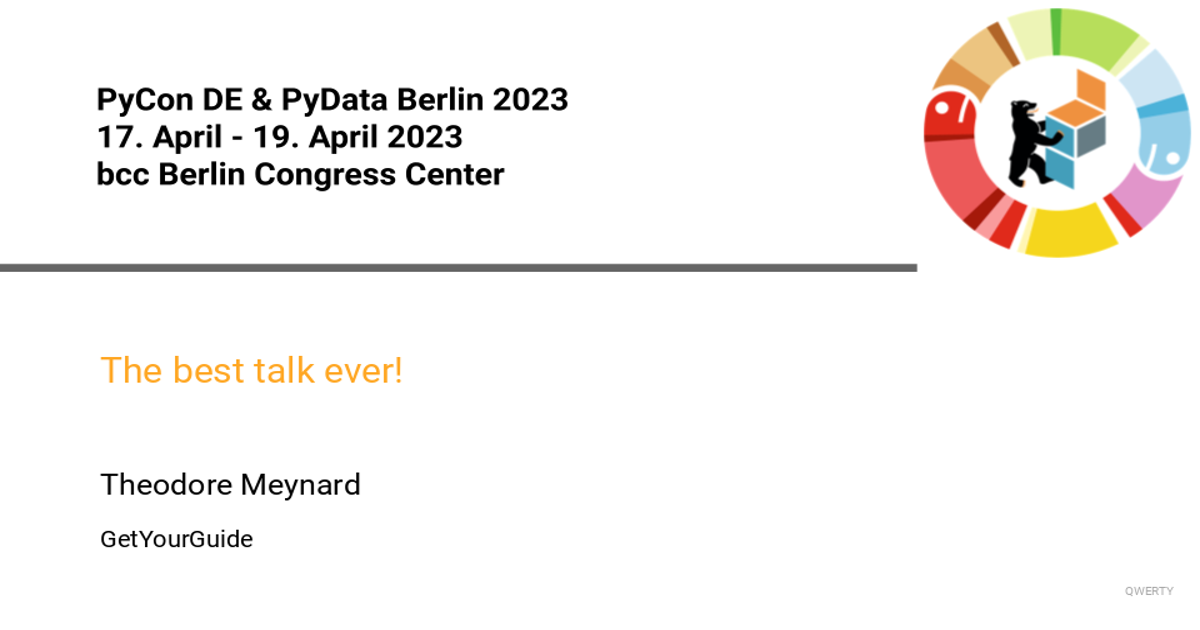

In [14]:
imgDraw = ImageDraw.Draw(img)

font_title = ImageFont.truetype(font_path, size=30)
font_name = ImageFont.truetype(font_path, size=25)
font_affiliation = ImageFont.truetype(font_path, size=20)
font_key = ImageFont.truetype(font_path, size=10)

imgDraw.text((80, 300), talkInfo.title, font=font_title, fill="#ffa724") 
imgDraw.text((80, 400), talkInfo.name, font=font_name, fill="#000000")
imgDraw.text((80, 450), talkInfo.affiliation, font=font_affiliation, fill="#000000")
imgDraw.text((900, 500), talkInfo.key, font=font_key, fill="#aaaaaa")

img.resize((1200, 630))

In [24]:
from pytanis import PretalxClient
from pytanis.pretalx import speakers_as_df

In [25]:
pretalx_client = PretalxClient(blocking=True)
pkrs_count, spkrs = pretalx_client.speakers("pyconde-pydata-berlin-2023", params={"questions": "all"})


0it [00:00, ?it/s]


In [27]:
spkrs_df = speakers_as_df(spkrs, with_questions=True)
spkrs_df

""


In [28]:
spkrs_df

""
